# Twitter Sentiment Analysis

This notebook aims to analyze Tweets made about the COVID-19 vaccine and determine whether the sentiment of the Tweets is negative, positive, or neutral.

## Libraries

In [1]:
import tweepy
import webbrowser
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import config
pd.set_option('display.max_colwidth', None)

from tweepy import OAuthHandler
from tweepy import API

import googletrans

## Gather data from Twitter API

In [2]:
# Developer API keys
# API keys in config.py in .gitignore
callback_uri = 'oob'

In [3]:
auth = OAuthHandler(config.consumer_key, config.consumer_secret, callback_uri)
auth.set_access_token(config.access_token, config.access_token_secret)

In [4]:
api = API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify= True)

In [5]:
# show my Twitter handle
me = api.me()
print(me.screen_name)

cassienutter1


In [ ]:
# simple query to get the hang of it
query = '#vaccine covid'
for i, status in enumerate(tweepy.Cursor(api.search, q= query).items(50)):
    print (i, status.text)

# filter only English tweets    
# query = '#vaccine covid'
# for i, status in enumerate(tweepy.Cursor(api.search, q= query, lang= 'en').items(50)):
#     print (i, status.text)

In [ ]:
''' This cell was run to collect the initial 5000 tweets and save them to a csv file
is commented out to prevent it from being run again


# collect 5000 tweets 
number_of_tweets = 5000
tweets = []
language = []
time = []

# only collect full text, language, and time it was posted
# remove any retweets '-RT'
for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                       tweet_mode = 'extended').items(number_of_tweets):
    tweets.append(i.full_text)
    language.append(i.lang)
    time.append(i.created_at)

# turn tweets / lists into dataframe
df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})

# save df to csv
df.to_csv('data/tweets.csv', index= False)
'''

Collect more tweets after waiting to avoid collecting the same tweets.

In [ ]:
# create function to get more tweets and add to existing csv
def get_more_tweets(num_tweets):
    number_of_tweets = num_tweets
    tweets = []
    language = []
    time = []

    # only collect full text, language, and time it was posted
    # remove any retweets '-RT'
    for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                           tweet_mode = 'extended').items(number_of_tweets):
        tweets.append(i.full_text)
        language.append(i.lang)
        time.append(i.created_at)
        
    # turn tweets / lists into dataframe
    df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})
    
    # add to existing csv file
    df.to_csv('data/tweets.csv', mode= 'a', index= False, header= False)

In [ ]:
get_more_tweets(50)

### Search for Tweets from 30 Days Ago

In [ ]:
# function to turn results into DataFrame
def extract_text_as_df(text_list):
    columns = set()
    allowed_types = [str, int]
    tweets_data = []
    for status in text_list:
        status_dict = dict(vars(status))
        keys = status_dict.keys()
        single_tweet_data = {"author": status.author.screen_name}
        for k in keys:
            try:
                v_type = type(status_dict[k])
            except:
                v_type = None
            if v_type != None:
                if v_type in allowed_types:
                    single_tweet_data[k] = status_dict[k]
                    columns.add(k)
        tweets_data.append(single_tweet_data)


    header_cols = list(columns)
    header_cols.append('author')
    df = pd.DataFrame(tweets_data, columns=header_cols)
    return df

In [ ]:
query = 'vaccine covid -RT'
results_30 = api.search_30_day('datacollection', query, maxResults= 100)

In [ ]:
old_results_df = extract_text_as_df(results_30)

In [ ]:
old_results_df

## Data Cleaning & EDA

In [6]:
df = pd.read_csv('data/tweets.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15400 entries, 0 to 15399
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      15400 non-null  object
 1   language  15400 non-null  object
 2   tweets    15400 non-null  object
dtypes: object(3)
memory usage: 361.1+ KB


### Check and Remove Duplicates

In [8]:
# check for duplicated tweets
duped = df[df.duplicated(subset= 'tweets')]
duped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 812 to 15142
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      37 non-null     object
 1   language  37 non-null     object
 2   tweets    37 non-null     object
dtypes: object(3)
memory usage: 1.2+ KB


In [9]:
# remove duplicates
df.drop_duplicates(subset= 'tweets', keep= 'first', inplace= True)
df.reset_index(drop= True, inplace= True)

# make sure they are gone
df.tweets.duplicated().sum()

0

### Looking at Languages

In [10]:
lang_df = df.sort_values('language')

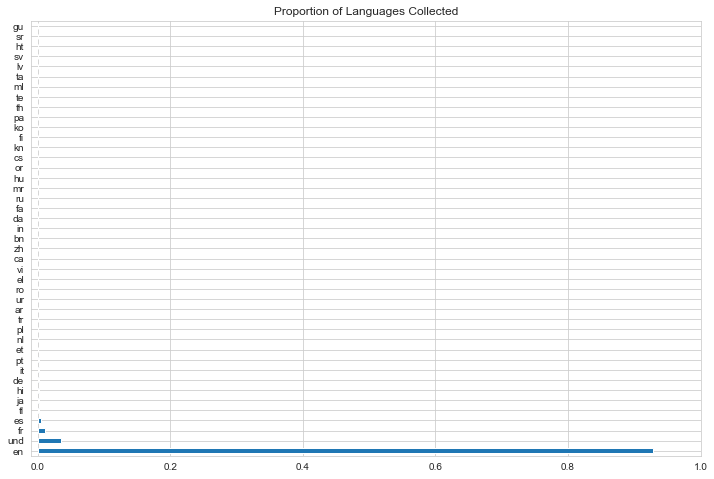

In [11]:
plt.figure(figsize= (12, 8))
lang_df.language.value_counts(normalize=True).plot(kind= 'barh')
plt.title('Proportion of Languages Collected')
plt.xlim(-.01, 1)
plt.show()

In [12]:
lang_df.language.value_counts(normalize=True)

en     0.928139
und    0.034954
fr     0.010935
es     0.004687
tl     0.002539
ja     0.002213
hi     0.001757
de     0.001367
it     0.001237
pt     0.001237
et     0.000976
nl     0.000911
pl     0.000781
tr     0.000716
ar     0.000586
ur     0.000521
ro     0.000521
el     0.000521
vi     0.000521
ca     0.000456
zh     0.000391
bn     0.000325
in     0.000325
da     0.000325
fa     0.000260
ru     0.000260
mr     0.000260
hu     0.000260
or     0.000195
cs     0.000195
kn     0.000195
fi     0.000195
ko     0.000130
pa     0.000130
th     0.000130
te     0.000130
ml     0.000130
ta     0.000130
lv     0.000130
sv     0.000130
ht     0.000065
sr     0.000065
gu     0.000065
Name: language, dtype: float64

In [13]:
# what are these languages? get table from url
URL = 'https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages'
tables = pd.read_html(URL)
print("There are : ",len(tables)," tables")
print(tables[0])

lang_table = tables[0]

There are :  1  tables
                        0              1
0                    Name  Language code
1       English (default)             en
2                  Arabic             ar
3                 Bengali             bn
4                   Czech             cs
5                  Danish             da
6                  German             de
7                   Greek             el
8                 Spanish             es
9                 Persian             fa
10                Finnish             fi
11               Filipino            fil
12                 French             fr
13                 Hebrew             he
14                  Hindi             hi
15              Hungarian             hu
16             Indonesian             id
17                Italian             it
18               Japanese             ja
19                 Korean             ko
20                  Malay            msa
21                  Dutch             nl
22              Norwegian         

In [14]:
# format table
header_row = 0
lang_table.columns = lang_table.iloc[header_row]
lang_table = lang_table.drop(header_row)
lang_table.reset_index(drop= True, inplace= True)

lang_table.replace('English (default)', 'English', inplace= True)
# lang_table

In [15]:
# save as csv in data folder
lang_table.to_csv('data/languages.csv', index= False)

In [16]:
# look at 'und' language 
df[df['language'] == 'und']

,time,language,tweets
1,2021-04-01 21:58:44,und,@and_kell @ds13_manon https://t.co/sKnTctMKcF
19,2021-04-01 21:58:14,und,https://t.co/j2braq4wFx
29,2021-04-01 21:57:58,und,@Pavlos80322302 @ds13_manon https://t.co/sKnTctMKcF
79,2021-04-01 21:56:21,und,👍🏼👍🏼👍🏼👍🏼 https://t.co/m68KkEqpOe
97,2021-04-01 21:55:44,und,https://t.co/Stomi0I13k
...,...,...,...
15238,2021-04-03 14:00:47,und,hmm #police #city #officers #department #capitol #biden #covid #vaccine #health #trump https://t.co/efCUe81TeR
15321,2021-04-03 18:44:00,und,https://t.co/r5EHFfzStE
15329,2021-04-03 18:43:52,und,https://t.co/z2wWjCiLyZ
15348,2021-04-03 18:42:50,und,https://t.co/drBoskkaEX


It appears that the 'und' or possibly 'undetermined' language are tweets that only include links. We will remove those from our DataFrame.

In [17]:
df = df[df['language'] != 'und']
# df.info()

Merge the data with the languages to see the whole name of languages

In [18]:
# merge data with language names
df2 = df.merge(lang_table, how= 'inner', left_on= 'language', right_on= 'Language code')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14731 entries, 0 to 14730
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   time           14731 non-null  object
 1   language       14731 non-null  object
 2   tweets         14731 non-null  object
 3   Name           14731 non-null  object
 4   Language code  14731 non-null  object
dtypes: object(5)
memory usage: 690.5+ KB


In [19]:
# drop extra columns and rename them and change dates to datetime and drop time
df2.drop(columns = ['language', 'Language code'], inplace= True)
df2.rename(columns={'Name': 'language'}, inplace= True)
df2['time'] = pd.to_datetime(df2['time']).dt.date
# df2

Let's see how many Tweets are in each language?

<AxesSubplot:xlabel='count', ylabel='language'>

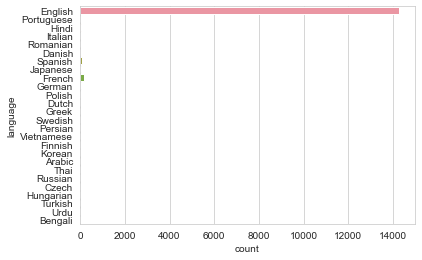

In [20]:
sns.countplot(y= 'language', data= df2)

The majority of Tweets are in English. Let's see what the other languages are.

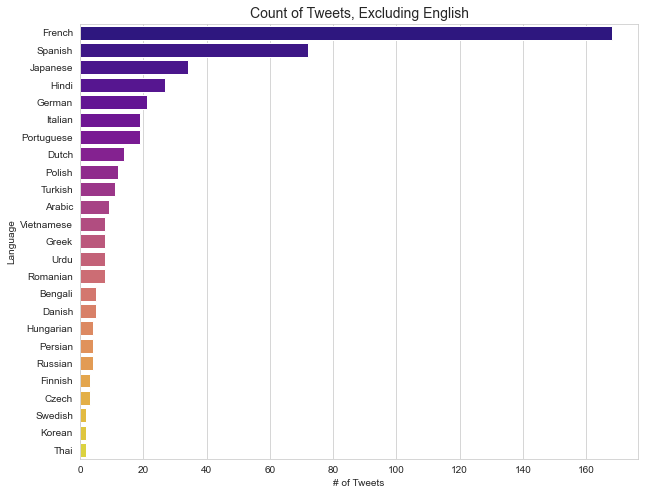

In [21]:
# countplot that excludes English to see detail
plt.figure(figsize= (10, 8))
sns.countplot(y= 'language', data= df2, palette='plasma',
              order= df2.language.value_counts().iloc[1:].index)
plt.title('Count of Tweets, Excluding English', fontsize= 14)
plt.xlabel('# of Tweets')
plt.ylabel('Language')
plt.show()

After English, the top 3 languages for Tweets about the COVID-19 vaccine are in French, Spanish, and Japanese.

In [ ]:
##translate all to english?
# googletrans?

In [39]:
fr_df = df2[df2['language'] == 'French']

In [40]:
fr_df

,time,tweets,language
14443,2021-04-01,@BenoitG70293865 @francoislegault Haha! Ça gars là c'est mon animal spirituel 🤣 Non mais faut tu être épaisse pour demander à un gars vacciné si ya peur de la Covid?,French
14444,2021-04-01,Donc mon père qui se bat maintenant depuis plus de 10 ans contre la sclérose en plaque doit se faire vacciné contre le covid sous prétexte que c'est une personne à risque ?? UNE PERSONNE À RISQUE ????\nC'est pas comme si il avait eu cette fichue maladie par un PUTAIN DE VACCIN !!,French
14445,2021-04-01,"@Latnaille77 Ils ont bien raison ! Avait il eu un contrôle sérologique avant sa vaccination ! Peut être avait-il eu déjà une forme asymptomatique du covid et était immunisé. On ne vaccine pas dans ce cas. Mais bon comme tout est fait en dépit du bon sens, combien de victimes à déplorer 😪",French
14446,2021-04-01,@Digitalchaos8 @Poulin2012 Mon voisin dûment vacciné dans les 1er Covid grave...,French
14447,2021-04-01,Gold D Roger serait en réalité mort après s'être vacciné contre la Covid-19. https://t.co/OvoulfUryJ,French
...,...,...,...
14606,2021-04-03,"Vacciné, le Président argentin positif au Covid: commentaire du concepteur du Spoutnik V: https://t.co/2fz8vLAVmL via @sputnik_fr",French
14607,2021-04-03,"Le président argentin, bien que vacciné, testé positif au Covid-19 https://t.co/lF6uxexcc2",French
14608,2021-04-03,"@QtScience ""Covid-19 : un octogénaire vacciné demande au Conseil d’État de ne plus être confiné""\n31.3.21 Mémoire de réponse :\nhttps://t.co/s9Gqa2Gjiq https://t.co/YG3K7D5C6c",French
14609,2021-04-03,"Le président argentin, vacciné, testé positif au virus du Covid-19 – franceinfo https://t.co/mpow3bjdfy",French


In [ ]:
# translator = Translator()
# translations = {}
# for column in fr_df.columns:
#     unique_elements = df[column].unique()
#     for element in unique_elements:
#         translations[element] = translator.translate(element).text

        
# translations

In [41]:
text = fr_df.tweets.loc[14610]
text

'@Parcamatt Non, pas sur Doctolib. Ce sera sur I-prof. Tu seras vacciné contre la Covid-1 (comme dirait le philoéditorialiste Onfray) puis pourras être promu au Grand Choix à la vaccination contre la Covid-2, etc. Si tu passes un entretien qualifiant, tu pourras sauter des étapes...'

In [36]:
import os
from google.oauth2 import service_account
from google.cloud import translate_v2 as translate

credentials = service_account.Credentials.from_service_account_file('../GCP_service_account.json')
translate_client = translate.Client(credentials= credentials)

In [37]:
# translate_client = translate.Client()
print(translate_client.get_languages())

[{'language': 'af', 'name': 'Afrikaans'}, {'language': 'sq', 'name': 'Albanian'}, {'language': 'am', 'name': 'Amharic'}, {'language': 'ar', 'name': 'Arabic'}, {'language': 'hy', 'name': 'Armenian'}, {'language': 'az', 'name': 'Azerbaijani'}, {'language': 'eu', 'name': 'Basque'}, {'language': 'be', 'name': 'Belarusian'}, {'language': 'bn', 'name': 'Bengali'}, {'language': 'bs', 'name': 'Bosnian'}, {'language': 'bg', 'name': 'Bulgarian'}, {'language': 'ca', 'name': 'Catalan'}, {'language': 'ceb', 'name': 'Cebuano'}, {'language': 'ny', 'name': 'Chichewa'}, {'language': 'zh-CN', 'name': 'Chinese (Simplified)'}, {'language': 'zh-TW', 'name': 'Chinese (Traditional)'}, {'language': 'co', 'name': 'Corsican'}, {'language': 'hr', 'name': 'Croatian'}, {'language': 'cs', 'name': 'Czech'}, {'language': 'da', 'name': 'Danish'}, {'language': 'nl', 'name': 'Dutch'}, {'language': 'en', 'name': 'English'}, {'language': 'eo', 'name': 'Esperanto'}, {'language': 'et', 'name': 'Estonian'}, {'language': 'tl'

In [44]:
# translate_client = translate.Client()
result = translate_client.translate(text, target_language= 'en')

In [46]:
result['translatedText']

'@Parcamatt No, not on Doctolib. It will be on I-prof. You will be vaccinated against Covid-1 (as the philo-editorialist Onfray would say) then you will be able to be promoted to the Grand Choix for vaccination against Covid-2, etc. If you pass a qualifying interview, you will be able to skip steps ...'

In [48]:
fr_en_tweets = []
for i in fr_df.tweets.loc[:]:
    result = translate_client.translate(i, target_language= 'en')
    fr_en_tweets.append(result['translatedText'])

In [49]:
fr_en_tweets

['@ BenoitG70293865 @francoislegault Haha! This guy is my spiritual animal 🤣 No, but do you have to be thick to ask a vaccinated guy if he&#39;s afraid of the Covid?',
 'So my father, who has been fighting multiple sclerosis for over 10 years now, must be vaccinated against covid on the pretext that he is a person at risk ?? A PERSON AT RISK ???? It&#39;s not like he got this damn disease from a FUCKING VACCINE !!',
 '@ Latnaille77 They are quite right! Had he had a serological check before his vaccination! Perhaps he had already had an asymptomatic form of covid and was immune. We do not vaccinate in this case. But hey, since everything is done in spite of common sense, how many victims to deplore 😪',
 '@ Digitalchaos8 @ Poulin2012 My neighbor duly vaccinated in the 1st serious Covid ...',
 'Gold D Roger is said to have actually died after being vaccinated against Covid-19. https://t.co/OvoulfUryJ',
 'Kamala Harris unveils ‘Covid-19 Community Corps’ to battle vaccine misinformation ht

In [ ]:
from google.cloud import translate_v2

In [23]:
from os import environ

In [24]:
project_id = environ.get('My First Project-a16389cc11b5.json')

In [ ]:
assert project_id
parent = f'projects/{project_id}'
client = translate.TranslationServiceClient()

### Start here:

In [36]:
import os
from google.oauth2 import service_account
from google.cloud import translate_v2 as translate

credentials = service_account.Credentials.from_service_account_file('../GCP_service_account.json')
translate_client = translate.Client(credentials= credentials)

In [37]:
# translate_client = translate.Client()
print(translate_client.get_languages())

[{'language': 'af', 'name': 'Afrikaans'}, {'language': 'sq', 'name': 'Albanian'}, {'language': 'am', 'name': 'Amharic'}, {'language': 'ar', 'name': 'Arabic'}, {'language': 'hy', 'name': 'Armenian'}, {'language': 'az', 'name': 'Azerbaijani'}, {'language': 'eu', 'name': 'Basque'}, {'language': 'be', 'name': 'Belarusian'}, {'language': 'bn', 'name': 'Bengali'}, {'language': 'bs', 'name': 'Bosnian'}, {'language': 'bg', 'name': 'Bulgarian'}, {'language': 'ca', 'name': 'Catalan'}, {'language': 'ceb', 'name': 'Cebuano'}, {'language': 'ny', 'name': 'Chichewa'}, {'language': 'zh-CN', 'name': 'Chinese (Simplified)'}, {'language': 'zh-TW', 'name': 'Chinese (Traditional)'}, {'language': 'co', 'name': 'Corsican'}, {'language': 'hr', 'name': 'Croatian'}, {'language': 'cs', 'name': 'Czech'}, {'language': 'da', 'name': 'Danish'}, {'language': 'nl', 'name': 'Dutch'}, {'language': 'en', 'name': 'English'}, {'language': 'eo', 'name': 'Esperanto'}, {'language': 'et', 'name': 'Estonian'}, {'language': 'tl'

In [42]:
text = fr_df.tweets.loc[14610]
text

'@Parcamatt Non, pas sur Doctolib. Ce sera sur I-prof. Tu seras vacciné contre la Covid-1 (comme dirait le philoéditorialiste Onfray) puis pourras être promu au Grand Choix à la vaccination contre la Covid-2, etc. Si tu passes un entretien qualifiant, tu pourras sauter des étapes...'

In [44]:
# translate_client = translate.Client()
result = translate_client.translate(text, target_language= 'en')

In [46]:
result['translatedText']

'@Parcamatt No, not on Doctolib. It will be on I-prof. You will be vaccinated against Covid-1 (as the philo-editorialist Onfray would say) then you will be able to be promoted to the Grand Choix for vaccination against Covid-2, etc. If you pass a qualifying interview, you will be able to skip steps ...'

## Text Sentiment
---
Does the tweet have a positive, negative, or neutral tone?

### Feature Engineering for Text Data
--- 
stopword removal
frequency distributions
lemmatization
bigramsm n-grams, and mutal information score

In [ ]:
# convert text to lowercase

In [ ]:
# remove punctuation

In [ ]:
# tokenization

In [ ]:
# stop words removal

In [ ]:
# lemmatization

In [ ]:
# Part of speech (POS) tagging